In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from collections import defaultdict, Counter
import random
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
import hydra
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from cgpos.utils.util import import_pkl, export_pkl, get_abs_dir

In [3]:
# Reset hydra
hydra.core.global_hydra.GlobalHydra.instance().clear()
# Load hydra params
initialize("../conf/", version_base=None)
config = compose(config_name='main')
# Init logger
logging.basicConfig(level=logging.INFO) 

In [4]:
# Load data
data_raw = import_pkl(config.perseus.featurized)
# Clean
vars = config.vars.pred
data = [word for word in data_raw if all(var in word for var in vars)]

INFO:cgpos.utils.util:Importing /home/tejomay/cgpos/data/processed/perseus_featurized.pkl


In [72]:
def ngram(sequence, n):
    """
    Generate ngram from a sequence of tokens.
    """
    len_sequence = len(sequence)
    n_passes = max(1, len_sequence - n + 1)
    return (tuple(sequence[i:(i + n)]) for i in range(n_passes))

def ngram_bos(data, n=1, var='pos'):
    """
    Generate n-grams for given data.
    """
    bos = defaultdict(Counter)
    for word in data:
        value = word[var]
        syllables = word['syllables']
        for gram in ngram(syllables, n):
            bos[gram][value] +=1 
    return bos

In [73]:
# Bag of syllables
def additive_recursive_ngram_bos_model(data, var='pos', n=2, train=0.8, verbose=True, seed=20, ngram_bos_func=ngram_bos, ngram_func=ngram):
    """
    Implement an additive recursive n-gram bag-of-syllables model to predict part-of-speech.

    Arguments
    - data: List of word dicts. (cf. config.perseus.featurized)
    - var: Variable to predict.
    - n: Depth of ngram.
    - train: Train split percentage (rest goes to test).
    - verbose: Print information.
    - seed: Reproduce a train-test split.
    """
    logger = logging.getLogger(__name__)
    logger.info(f"Traning additive recursive n-gram bag-of-syllables model to predict {var}: n={n}")
    
    # Train test split
    random.seed(seed)
    shuffled = random.sample(data, len(data))
    train_ind = int(len(data) * train)
    train_data = shuffled[:train_ind] 
    test_data = shuffled[train_ind:]

    if verbose:
        logger.info(f"Train-test split {train}: (train={len(train_data)}, test={len(test_data)}) [seed={seed}]")
 
    def recursive_ngram_lookup(sequence, grams_dict, n, ngram_func=ngram):
        """
        Recursively looks up ngrams to find count distributions for a word.
        """
        if (n == 0):
            return Counter()

        total_dist = Counter()
        for gram in ngram_func(sequence, n):
            if gram in grams_dict[n]:
                total_dist += grams_dict[n][gram]
            else:
                sub_dist = recursive_ngram_lookup(gram, grams_dict, n - 1)
                total_dist += sub_dist
        
        return total_dist

    # Train
    train_grams = {}
    for i in range(1, n + 1):
        train_gram = ngram_bos(train_data, n=i, var=var)
        train_grams[i] = train_gram

    # Test
    forms = []
    true_labels = []
    pred_labels = []
    gram_dists = []
    for word in test_data:
        # Get data
        pred_label = None
        form = word['form']
        true_label = word[var]
        syllables = word['syllables']
        # Train
        gram_dist = recursive_ngram_lookup(syllables, train_grams, n, ngram)
        if gram_dist:
            pred_label = max(gram_dist, key=gram_dist.get)
        # Append results
        forms.append(form)
        true_labels.append(true_label)
        pred_labels.append(pred_label)
        gram_dists.append(gram_dist)

    # Calculate metrics
    cat2int = import_pkl(config.perseus.cat2int)
    int2cat = import_pkl(config.perseus.int2cat)
    true = np.array([cat2int[(var, label)] for label in true_labels])
    pred = np.array([cat2int.get((var, label), 0) for label in pred_labels])
    labels = [int2cat[(var, i)] for i in np.unique(true)]
    
    metrics = {
        'accuracy': sum(true == pred) / len(test_data),
        'classification_report': classification_report(true, pred, target_names=labels),
        'confusion': pd.DataFrame(confusion_matrix(true, pred), index=labels, columns=labels),
    }

    if verbose:
        logger.info(f"Accuracy: {float(metrics['accuracy']) * 100:.2f}%. Classification report:\n" + metrics['classification_report'])

    # Return results
    results = {
        'forms': forms,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
        'gram_dists': gram_dists,
        'true': true,
        'pred': pred,
        'labels': labels,
        'train_grams': train_grams,    
        'metrics': metrics,
        'seed': seed,
    }
    
    return results


def cv(data, model=additive_recursive_ngram_bos_model, folds=10, **kwargs):
    logger = logging.getLogger(__name__)
    logger.info(f"Running {folds}-fold CV on n-gram bag-of-syllables model:")
    results = []
    accuracies = []
    for i in range(1, folds + 1):
        logger.info(f"Training fold {i}:")
        seed = random.randint(1, 2**10)
        result = model(data, seed=seed, **kwargs)
        accuracy = result['accuracy']
        results.append(result)
        accuracies.append(accuracy)
    logger.info(f"{folds}-fold CV results: accuracy {np.mean(accuracies) * 100:.2f}%, std {np.std(accuracies):.2f}")
    accuracies.append(accuracy)
    return results

In [74]:
results = {}
for var in vars:
    results[var] = additive_recursive_ngram_bos_model(data, n=5, var=var, seed=400)

INFO:__main__:Traning additive recursive n-gram bag-of-syllables model to predict pos: n=5
INFO:__main__:Train-test split 0.8: (train=439900, test=109976) [seed=400]
INFO:cgpos.utils.util:Importing /home/tejomay/cgpos/data/reference/cat2int.pkl
INFO:cgpos.utils.util:Importing /home/tejomay/cgpos/data/reference/int2cat.pkl
INFO:__main__:Accuracy: 89.59%. Classification report:
              precision    recall  f1-score   support

         N/A       0.13      0.09      0.11       122
     article       0.85      0.97      0.90      5881
        noun       0.92      0.94      0.93     22082
   adjective       0.90      0.82      0.86     12208
     pronoun       0.84      0.81      0.83      7057
        verb       0.94      0.94      0.94     19488
      adverb       0.89      0.60      0.71      9667
  adposition       0.97      0.98      0.97      5461
 conjunction       0.76      0.86      0.81      5471
     numeral       0.73      0.70      0.71       133
interjection       0.98   

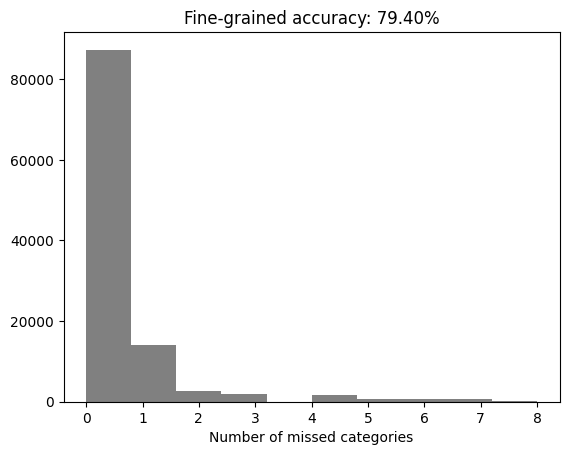

In [75]:
# Get fine-grained accuracy
true = []
pred = []
for var, result in results.items():
    true.append(result['true'])
    pred.append(result['pred'])
true = np.stack(true).T
pred = np.stack(pred).T

fine_grained = []
for i in range(len(true)):
    fine_grained.append(sum(true[i] == pred[i]))
fine_grained = np.array(fine_grained)

# Make hist
plt.hist(9 - fine_grained, color='grey')
plt.title(f'Fine-grained accuracy: {np.mean(fine_grained == 9) * 100:0.2f}%')
plt.xlabel('Number of missed categories')
plt.ylabel('')
plt.show()

In [81]:
forms = np.array(results['pos']['forms'])
true_labels = []
pred_labels = []
for var, result in results.items():
    true_labels.append(result['true_labels'])
    pred_labels.append(result['pred_labels'])
true_labels = np.stack(true_labels).T
pred_labels = np.stack(pred_labels).T

In [105]:
df = pd.DataFrame([forms, true_labels, pred_labels, fine_grained], index=['form', 'true', 'pred', 'num_correct']).T
df['true_pos']=df.apply(lambda d: d['true'][0], axis=1)
df['pred_pos']=df.apply(lambda d: d['pred'][0], axis=1)


In [114]:
df

,form,true,pred,num_correct,true_pos,pred_pos
0,στόρεσαν,"[verb, third person, plural, aorist, indicativ...","[verb, third person, plural, aorist, indicativ...",9,verb,verb
1,δίλογχον,"[adjective, N/A, singular, N/A, N/A, N/A, femi...","[noun, N/A, singular, N/A, N/A, N/A, masculine...",7,adjective,noun
2,ἄμαχος,"[adjective, N/A, singular, N/A, N/A, N/A, femi...","[noun, N/A, singular, N/A, N/A, N/A, masculine...",7,adjective,noun
3,οὕτω,"[adverb, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A]","[adverb, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A]",9,adverb,adverb
4,μέλαιναν,"[adjective, N/A, singular, N/A, N/A, N/A, femi...","[adjective, N/A, singular, N/A, N/A, N/A, femi...",9,adjective,adjective
...,...,...,...,...,...,...
109971,Διὶ,"[noun, N/A, singular, N/A, N/A, N/A, masculine...","[noun, N/A, singular, N/A, N/A, N/A, masculine...",9,noun,noun
109972,ὀίω,"[verb, first person, singular, present, indica...","[verb, first person, singular, present, indica...",9,verb,verb
109973,χαλάσαι,"[verb, N/A, N/A, aorist, infinitive, active, N...","[verb, N/A, N/A, aorist, infinitive, active, N...",9,verb,verb
109974,.,"[punctuation, N/A, N/A, N/A, N/A, N/A, N/A, N/...","[punctuation, N/A, N/A, N/A, N/A, N/A, N/A, N/...",9,punctuation,punctuation
